<a href="https://colab.research.google.com/github/Intel-Unnathi-Intership-Program/Product_Sentiment_Analysis/blob/main/TrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')
warnings.warn("This will not show")

pd.set_option('display.max_columns', None)
import nltk

In [ ]:
!pip install gdown



In [ ]:
#https://docs.google.com/spreadsheets/d/1bUTi9y9AfBPUhSfBTmjJ1QLS1ctkcqi2/edit?usp=sharing&ouid=113442891629380336523&rtpof=true&sd=true


Downloading...
From: https://drive.google.com/uc?id=1bUTi9y9AfBPUhSfBTmjJ1QLS1ctkcqi2&export=download
To: /content/Extracted_Dataset.xlsx
100%|██████████| 290k/290k [00:00<00:00, 71.8MB/s]


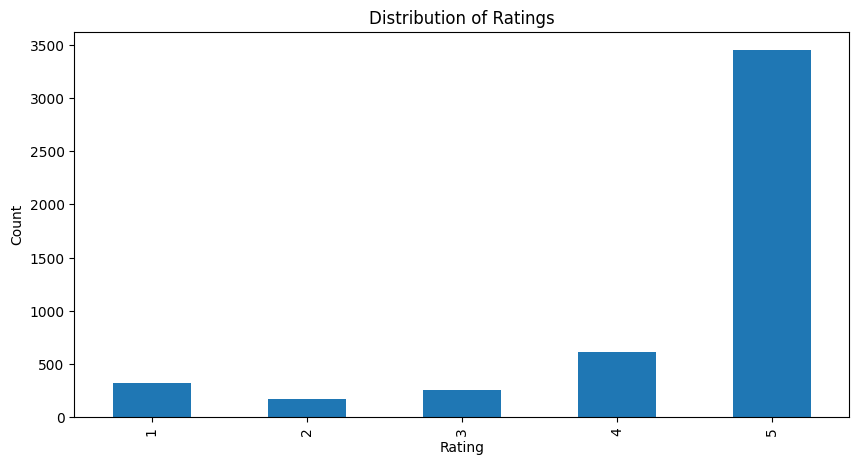

In [ ]:
import gdown
import pandas as pd

# Google Drive file ID
file_id = '1bUTi9y9AfBPUhSfBTmjJ1QLS1ctkcqi2'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
output = 'Extracted_Dataset.xlsx'

# Download the file from Google Drive
gdown.download(url, output, quiet=False)

# Read the downloaded Excel file
df = pd.read_excel(output)

df['review_rating'].value_counts().sort_index().plot(kind='bar', title='count of reviews by stars', figsize=(10,5))
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


BASIC NLTK

In [ ]:
# Install necessary libraries
!pip install nltk

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Example text
lexample = df['review_body'][5]
example = lexample

# Tokenize the text
tokens = nltk.word_tokenize(example)

# POS Tagging
tagged = nltk.pos_tag(tokens)

# Named Entity Chunking
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S excellent/JJ cpu/NN game/NN high/JJ quality/NN gpu/VBP support/NN)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


VADAR sentiment analyser

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.7506}

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_body']
        if isinstance(text, str):  # Check if text is a string
            myid = row['id']
            res[myid] = sia.polarity_scores(text)
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/4806 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')
#Now we have sentiment score and meta data
vaders

id    neg    neu    pos  compound  \
0        1  0.000  0.911  0.089    0.7964   
1        2  0.000  0.000  1.000    0.5719   
2        3  0.000  0.663  0.337    0.7269   
3        4  0.000  0.466  0.534    0.8834   
4        5  0.000  0.000  1.000    0.2023   
...    ...    ...    ...    ...       ...   
4800  4811  0.097  0.681  0.222    0.5423   
4801  4812  0.160  0.592  0.249    0.3612   
4802  4813  0.039  0.606  0.354    0.9906   
4803  4814  0.000  0.775  0.225    0.7269   
4804  4815  0.000  0.675  0.325    0.9371   

                                             Product  review_rating  \
0                      Intel Core i3-13100 Processor              4   
1                      Intel Core i3-13100 Processor              5   
2                      Intel Core i3-13100 Processor              5   
3                      Intel Core i3-13100 Processor              5   
4                      Intel Core i3-13100 Processor              5   
...                                              ...            ...   
4800  Intel Core i9-12900KF Gaming Desktop Processor              5   
4801  Intel Core i9-12900KF Gaming Desktop Processor              5   
4802  Intel Core i9-12900KF Gaming Desktop Processor              5   
4803  Intel Core i9-12900KF Gaming Desktop Processor              5   
4804  Intel Core i9-12900KF Gaming Desktop Processor              4   

                                            review_body  
0     th generation intel core processors total core...  
1                                               perfect  
2     didnt mention processor come heatsink buy bett...  
3     great entry level processor work like expensiv...  
4                                                   top  
...                                                 ...  
4800  complaints besides need strong cooler get real...  
4801  cpu best core thread affordable price scream f...  
4802  devote amd fan x ace start bother dread usb is...  
4803  kf prior one fast even overclockedand nice p c...  
4804  technology one best things invent product good...  

[4805 rows x 8 columns]

plot VADERS result

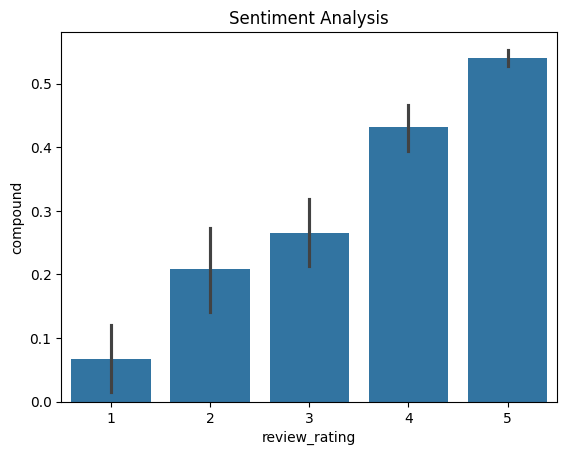

In [ ]:
sns.barplot(data=vaders, x='review_rating', y='compound')
plt.title('Sentiment Analysis')
plt.show()

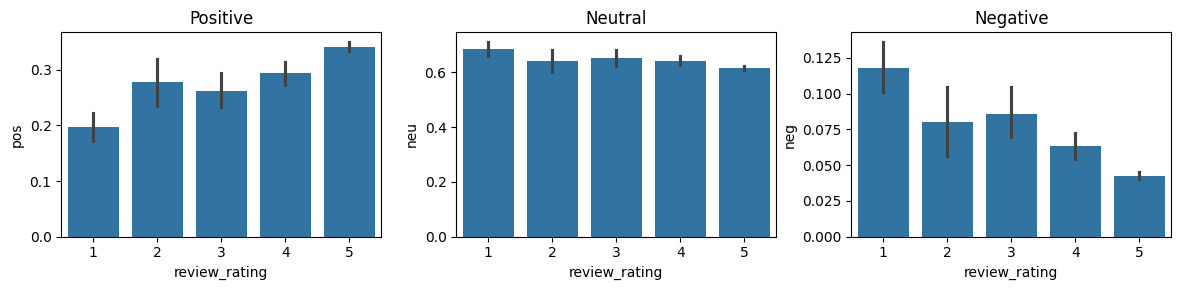

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='review_rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='review_rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='review_rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Roberta Pretrained Model

In [ ]:
!pip install transformers



In [ ]:
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
#Vadar result on example to test
print(example)
sia.polarity_scores(example)


excellent cpu game high quality gpu support


{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.7506}

In [ ]:
#Run for roberta model on example
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.006181897, 'roberta_neu': 0.068998404, 'roberta_pos': 0.92481977}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_body']
        if isinstance(text, str):  # Check if text is a string
            myid = row['id']
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = polarity_scores_roberta(text)
            both = {**vader_result_rename, **roberta_result}
            res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/4806 [00:00<?, ?it/s]

Broke for id 1547
Broke for id 2044
Broke for id 2062
Broke for id 2066
Broke for id 2125
Broke for id 2161
Broke for id 2592
Broke for id 2692
Broke for id 2792
Broke for id 3000
Broke for id 3007
Broke for id 3138
Broke for id 3328
Broke for id 3717
Broke for id 3724


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')
results_df

id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        1      0.000      0.911      0.089          0.7964     0.127272   
1        2      0.000      0.000      1.000          0.5719     0.083121   
2        3      0.000      0.663      0.337          0.7269     0.233796   
3        4      0.000      0.466      0.534          0.8834     0.020131   
4        5      0.000      0.000      1.000          0.2023     0.137306   
...    ...        ...        ...        ...             ...          ...   
4785  4811      0.097      0.681      0.222          0.5423     0.028254   
4786  4812      0.160      0.592      0.249          0.3612     0.019147   
4787  4813      0.039      0.606      0.354          0.9906     0.009748   
4788  4814      0.000      0.775      0.225          0.7269     0.009494   
4789  4815      0.000      0.675      0.325          0.9371     0.067936   

      roberta_neu  roberta_pos  \
0        0.840364     0.032364   
1        0.383298     0.533581   
2        0.609915     0.156289   
3        0.133130     0.846739   
4        0.583286     0.279407   
...           ...          ...   
4785     0.397706     0.574040   
4786     0.261897     0.718956   
4787     0.122818     0.867434   
4788     0.372902     0.617605   
4789     0.356325     0.575740   

                                             Product  review_rating  \
0                      Intel Core i3-13100 Processor              4   
1                      Intel Core i3-13100 Processor              5   
2                      Intel Core i3-13100 Processor              5   
3                      Intel Core i3-13100 Processor              5   
4                      Intel Core i3-13100 Processor              5   
...                                              ...            ...   
4785  Intel Core i9-12900KF Gaming Desktop Processor              5   
4786  Intel Core i9-12900KF Gaming Desktop Processor              5   
4787  Intel Core i9-12900KF Gaming Desktop Processor              5   
4788  Intel Core i9-12900KF Gaming Desktop Processor              5   
4789  Intel Core i9-12900KF Gaming Desktop Processor              4   

                                            review_body  
0     th generation intel core processors total core...  
1                                               perfect  
2     didnt mention processor come heatsink buy bett...  
3     great entry level processor work like expensiv...  
4                                                   top  
...                                                 ...  
4785  complaints besides need strong cooler get real...  
4786  cpu best core thread affordable price scream f...  
4787  devote amd fan x ace start bother dread usb is...  
4788  kf prior one fast even overclockedand nice p c...  
4789  technology one best things invent product good...  

[4790 rows x 11 columns]

In [ ]:

# Function to compute combined sentiment scores
def compute_combined_sentiment(row):
    combined_neg = (row['vader_neg'] + row['roberta_neg']) / 2
    combined_neu = (row['vader_neu'] + row['roberta_neu']) / 2
    combined_pos = (row['vader_pos'] + row['roberta_pos']) / 2
    return pd.Series([combined_neg, combined_neu, combined_pos])

# Apply the function to each row in the DataFrame
results_df[['combined_neg', 'combined_neu', 'combined_pos']] = results_df.apply(compute_combined_sentiment, axis=1)

# Display the updated DataFrame
print(results_df[['id', 'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'combined_neg', 'combined_neu', 'combined_pos']])


        id  vader_neg  vader_neu  vader_pos  roberta_neg  roberta_neu  \
0        1      0.000      0.911      0.089     0.127272     0.840364   
1        2      0.000      0.000      1.000     0.083121     0.383298   
2        3      0.000      0.663      0.337     0.233796     0.609915   
3        4      0.000      0.466      0.534     0.020131     0.133130   
4        5      0.000      0.000      1.000     0.137306     0.583286   
...    ...        ...        ...        ...          ...          ...   
4785  4811      0.097      0.681      0.222     0.028254     0.397706   
4786  4812      0.160      0.592      0.249     0.019147     0.261897   
4787  4813      0.039      0.606      0.354     0.009748     0.122818   
4788  4814      0.000      0.775      0.225     0.009494     0.372902   
4789  4815      0.000      0.675      0.325     0.067936     0.356325   

      roberta_pos  combined_neg  combined_neu  combined_pos  
0        0.032364      0.063636      0.875682      0.060682  

In [ ]:
# Define a function to classify sentiment based on combined scores
def classify_sentiment(row):
    if row['combined_pos'] > row['combined_neg'] and row['combined_pos'] > row['combined_neu']:
        return 'positive'
    elif row['combined_neg'] > row['combined_pos'] and row['combined_neg'] > row['combined_neu']:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to each row in the DataFrame
results_df['sentiment'] = results_df.apply(classify_sentiment, axis=1)

# Display the updated DataFrame with the new sentiment column
print(results_df[['id', 'review_body', 'sentiment']])




        id                                        review_body sentiment
0        1  th generation intel core processors total core...   neutral
1        2                                            perfect  positive
2        3  didnt mention processor come heatsink buy bett...   neutral
3        4  great entry level processor work like expensiv...  positive
4        5                                                top  positive
...    ...                                                ...       ...
4785  4811  complaints besides need strong cooler get real...   neutral
4786  4812  cpu best core thread affordable price scream f...  positive
4787  4813  devote amd fan x ace start bother dread usb is...  positive
4788  4814  kf prior one fast even overclockedand nice p c...   neutral
4789  4815  technology one best things invent product good...   neutral

[4790 rows x 3 columns]


In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-adjust column width

results_df


id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  roberta_neu  \
0        1      0.000      0.911      0.089          0.7964     0.127272     0.840364   
1        2      0.000      0.000      1.000          0.5719     0.083121     0.383298   
2        3      0.000      0.663      0.337          0.7269     0.233796     0.609915   
3        4      0.000      0.466      0.534          0.8834     0.020131     0.133130   
4        5      0.000      0.000      1.000          0.2023     0.137306     0.583286   
5        6      0.000      0.439      0.561          0.7506     0.006182     0.068998   
6        7      0.000      0.196      0.804          0.6249     0.007138     0.061378   
7        8      0.000      1.000      0.000          0.0000     0.029328     0.917978   
8        9      0.000      0.687      0.313          0.6249     0.052736     0.720152   
9       10      0.035      0.705      0.259          0.8360     0.020780     0.232830   
10      11      0.444      0.556      0.000         -0.1531     0.408708     0.536723   
11      12      0.000      0.000      1.000          0.3612     0.059447     0.585431   
12      13      0.101      0.697      0.202          0.8375     0.045742     0.291108   
13      14      0.041      0.729      0.229          0.9849     0.022163     0.314429   
14      15      0.000      0.578      0.422          0.9274     0.007817     0.115105   
15      16      0.000      0.503      0.497          0.8360     0.004349     0.070739   
16      17      0.000      1.000      0.000          0.0000     0.191664     0.613422   
17      18      0.039      0.758      0.203          0.9413     0.030799     0.535252   
18      19      0.000      0.448      0.552          0.9022     0.016695     0.116644   
19      20      0.265      0.498      0.237         -0.4404     0.606933     0.339250   
20      21      0.000      0.659      0.341          0.7351     0.005387     0.113013   
21      22      0.000      0.759      0.241          0.9184     0.018901     0.183066   
22      23      0.000      0.256      0.744          0.4404     0.011240     0.101536   
23      24      0.000      0.704      0.296          0.2732     0.009989     0.197392   
24      25      0.000      0.497      0.503          0.8442     0.007390     0.125203   
25      26      0.000      0.776      0.224          0.8689     0.030393     0.234247   
26      27      0.000      0.538      0.462          0.9333     0.018452     0.375778   
27      28      0.100      0.514      0.386          0.7965     0.020078     0.316936   
28      29      0.000      0.802      0.198          0.6369     0.024290     0.389348   
29      30      0.124      0.627      0.249          0.9652     0.085288     0.538646   
30      31      0.133      0.661      0.206          0.2467     0.188242     0.700072   
31      32      0.000      0.828      0.172          0.4404     0.088388     0.707285   
32      33      0.093      0.741      0.166          0.8274     0.025941     0.268873   
33      34      0.081      0.478      0.442          0.8777     0.013253     0.186471   
34      35      0.167      0.833      0.000         -0.3400     0.492380     0.477348   
35      36      0.052      0.765      0.184          0.7845     0.062977     0.550773   
36      37      0.000      1.000      0.000          0.0000     0.149707     0.716986   
37      38      0.000      0.525      0.475          0.9441     0.028457     0.483175   
38      39      0.000      0.898      0.102          0.6369     0.029369     0.691827   
39      40      0.000      1.000      0.000          0.0000     0.135375     0.794297   
40      41      0.000      0.700      0.300          0.4588     0.006530     0.334437   
41      42      0.000      0.843      0.157          0.6249     0.011686     0.459530   
42      43      0.074      0.726      0.200          0.5368     0.303030     0.608189   
43      44      0.000      0.669      0.331          0.6621     0.042757     0.339764   
44 

In [ ]:
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Specify the path in your Google Drive where you want to save the Excel file
excel_file_path = 'https://drive.google.com/drive/my-drive/results.xlsx'

# Save DataFrame to Excel
results_df.to_excel(excel_file_path, index=False)

print(f"DataFrame successfully saved to '{excel_file_path}'")




Mounted at /content/drive
DataFrame successfully saved to 'https://drive.google.com/drive/my-drive/results.xlsx'


Compare Scores between models

In [ ]:
results_df.columns


Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Product', 'review_rating',
       'review_body', 'combined_neg', 'combined_neu', 'combined_pos',
       'sentiment'],
      dtype='object')

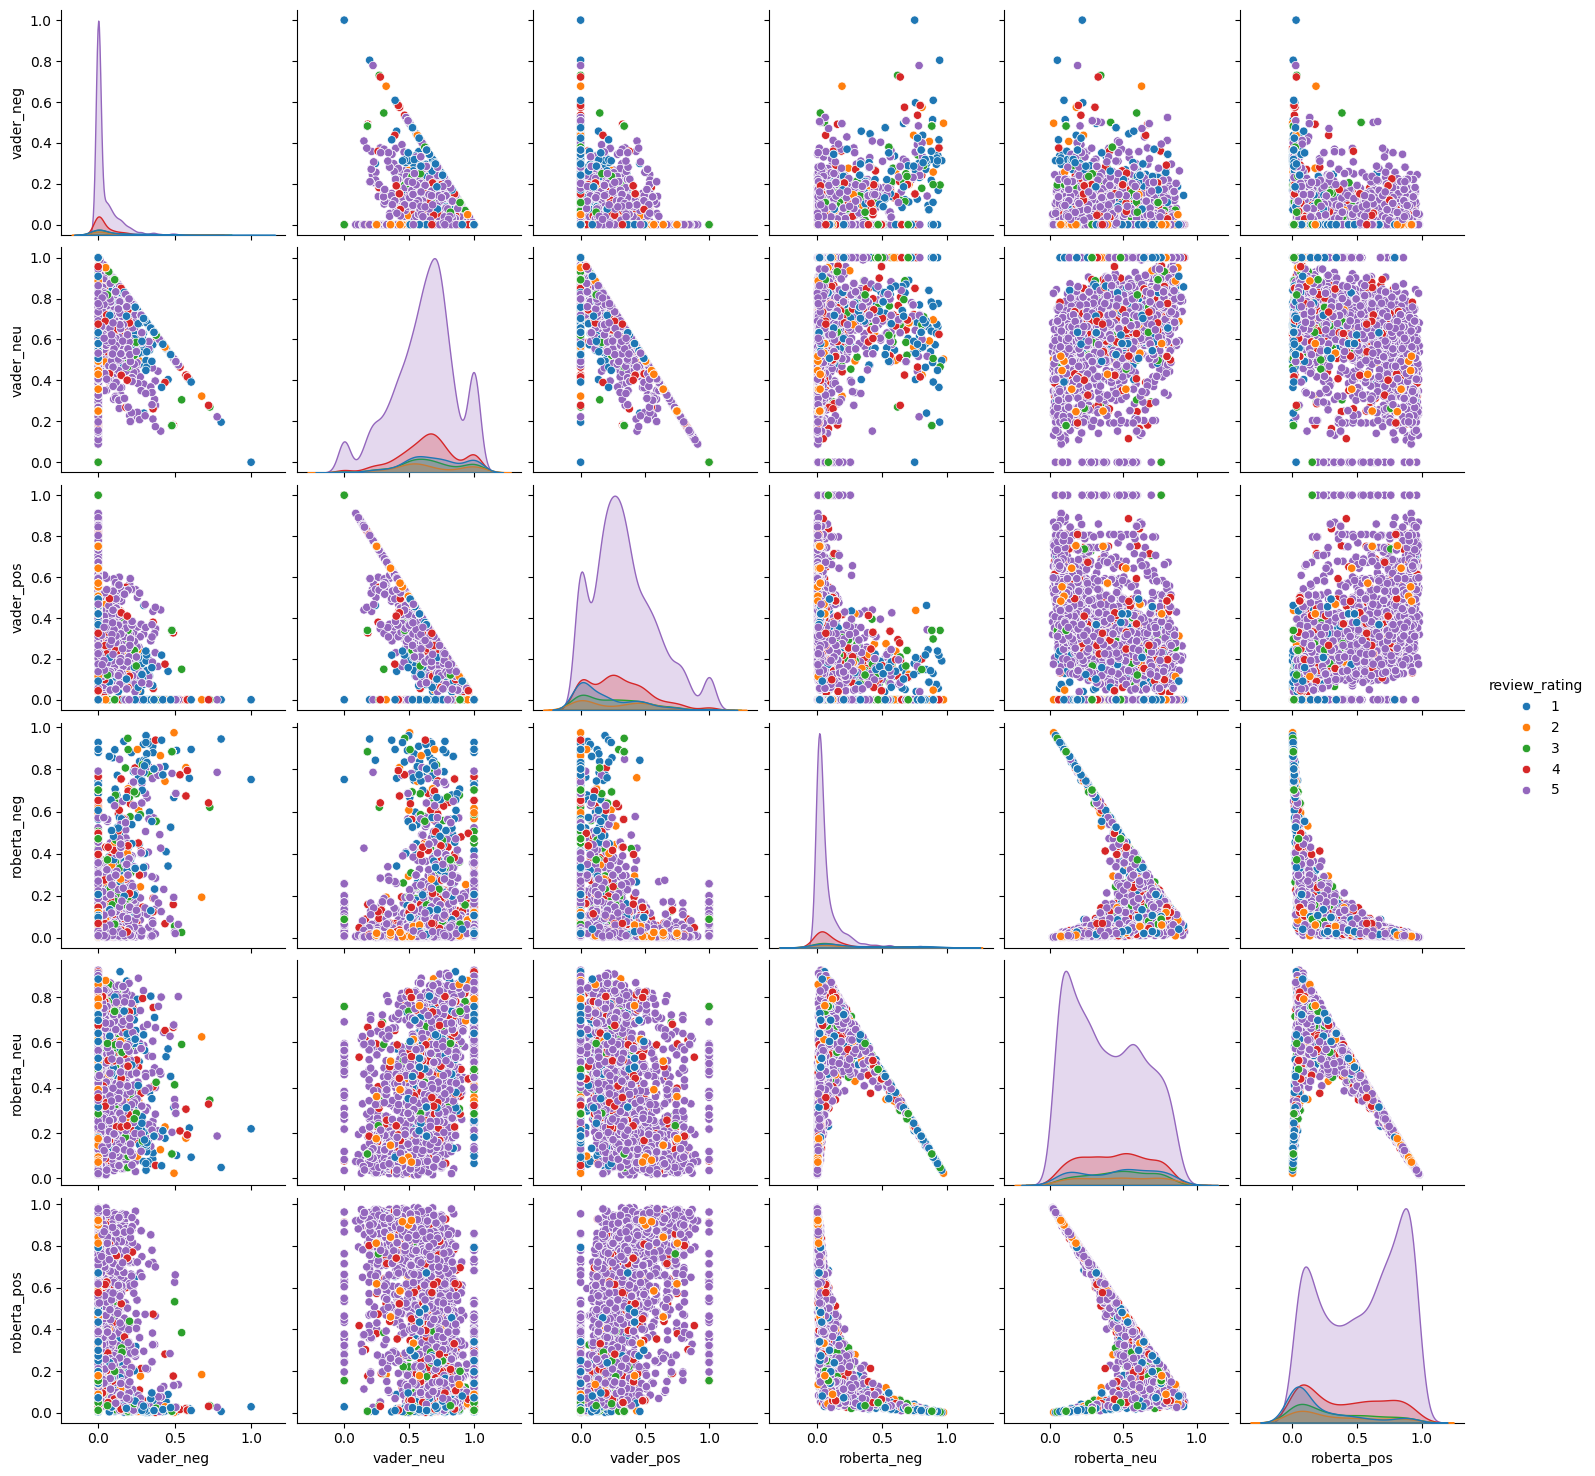

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='review_rating',
            palette='tab10')
plt.show()

In [26]:
!pip install rake-nltk
!pip install nltk
!pip install wordcloud matplotlib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Downloading...
From: https://drive.google.com/uc?id=1bUTi9y9AfBPUhSfBTmjJ1QLS1ctkcqi2
To: /content/Extracted_Dataset.xlsx
100%|██████████| 290k/290k [00:00<00:00, 73.1MB/s]


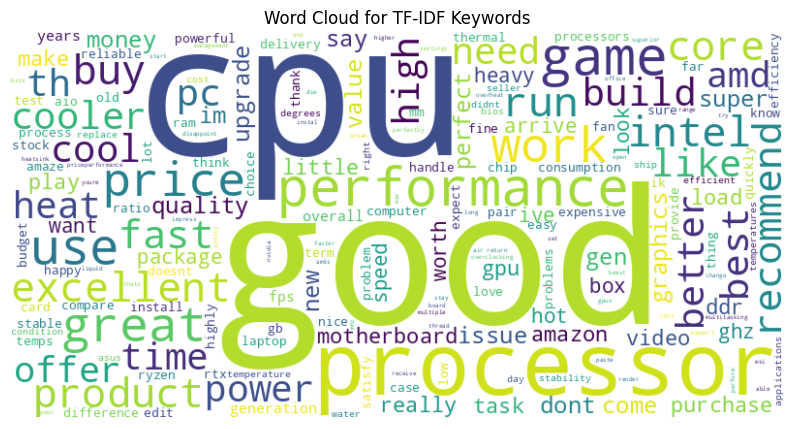

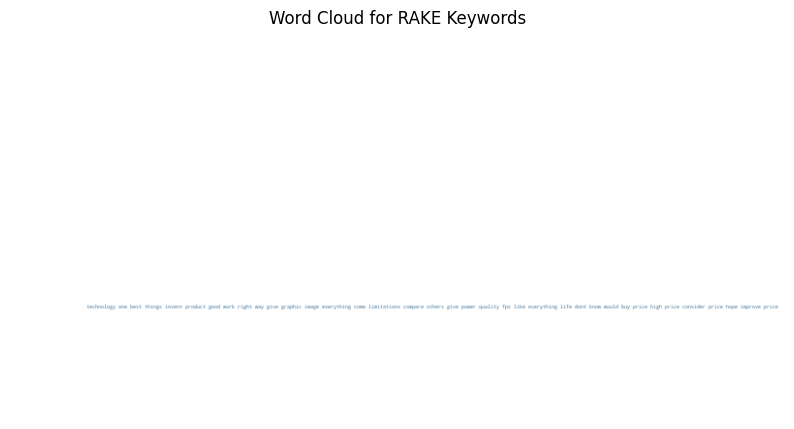

In [28]:
import pandas as pd
import re
import gdown
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK 'punkt' resource
nltk.download('punkt')

# Download the file from Google Drive
file_id = '1bUTi9y9AfBPUhSfBTmjJ1QLS1ctkcqi2'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'Extracted_Dataset.xlsx'
gdown.download(url, output, quiet=False)

# Read the downloaded Excel file
df = pd.read_excel(output)

# Clean and preprocess text data
df['cleaned_review'] = df['review_body'].apply(lambda x: re.sub(r'\W', ' ', str(x)))  # Remove non-word characters
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'\s+', ' ', str(x).lower().strip()))  # Normalize whitespace and convert to lowercase

# TF-IDF Vectorization
reviews_text = df['cleaned_review'].tolist()
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, min_df=0.01, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_text)

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
keywords_tfidf = {feature_names[i]: tfidf_scores[i] for i in range(len(feature_names))}

sorted_tfidf_keywords = sorted(keywords_tfidf.items(), key=lambda x: x[1], reverse=True)
top_tfidf_keywords = dict(sorted_tfidf_keywords[:300])  # Get top 300 TF-IDF keywords as a dictionary

# Generate Word Cloud for TF-IDF Keywords
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_tfidf_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for TF-IDF Keywords')
plt.show()

# RAKE Keyword Extraction
r = Rake()  # Initialize RAKE
df['rake_keywords'] = df['cleaned_review'].apply(lambda x: r.extract_keywords_from_text(x))
df['rake_keywords'] = df['cleaned_review'].apply(lambda x: r.get_ranked_phrases_with_scores())

# Extract RAKE keywords and their scores properly
rake_keywords_scores = []
for index, row in df.iterrows():
    rake_keywords_scores.extend(row['rake_keywords'])

# Create a dictionary of RAKE keywords with their scores
top_rake_keywords = {keyword: score for score, keyword in rake_keywords_scores[:300]}

# Generate Word Cloud for RAKE Keywords
wordcloud_rake = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_rake_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_rake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for RAKE Keywords')
plt.show()
